# Pricing Models 0, 1, 2, 3 Measurement

Besides the first pricing model (`pricing_model_0`) that train word2vec with full corpus and find 10 most similar challenge and taken average of their prizes as estimate. I've build 3 more pricing models:

1. Training word2vec model with **_corpus that deletes overlap sections_**, then find 10 most similar challenge and take average of their prizes as estimate
2. Training word2vec model with **_corpus that detects phrases (more than one word)_**, then find 10 most similar challenge and take average of their prizes as estimate
3. Training K-Near Neighboors model with:
   - X: document vectors calculated from pricing_model_0 appending meta data of challenges
   - y: actual total prize

Here below I will demonstrate the result.

In [1]:
import os
import json
from collections import defaultdict

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from tc_main import TopCoder

pd.set_option('display.max_rows', 150)

MODELS = (0, 1, 2)
TRACKS = ('all', 'develop', 'design')
DIMENSIONS = range(100, 1100, 100)

topcoder = TopCoder()

/Users/benjamin/Documents/Academy/SSW900/code/DataAnalysis/venv/lib/python3.7/site-packages/bs4/__init__.py:333: MarkupResemblesLocatorWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [2]:
pm_measure_dfs = defaultdict(lambda: defaultdict(dict))

for model in MODELS:
    for track in TRACKS:
        for dimension in DIMENSIONS:
            with open(os.path.join(os.curdir, f'pricing_model_{model}', f'{track}_track', 'measures', f'measure_{dimension}D.json')) as f:
                pm_measure_dfs[model][track][dimension] = pd.read_json(f, orient='records').set_index('index')


In [3]:
MMRE = []
for model in MODELS:
    for track in TRACKS:
        for dimension in DIMENSIONS:
            MMRE.append(dict(track=track, dimension=dimension, model=model, mmre=pm_measure_dfs[model][track][dimension]['MRE'].mean()))

mmre_df = pd.DataFrame(MMRE)

The Mean MRE by track and dimension is shown below

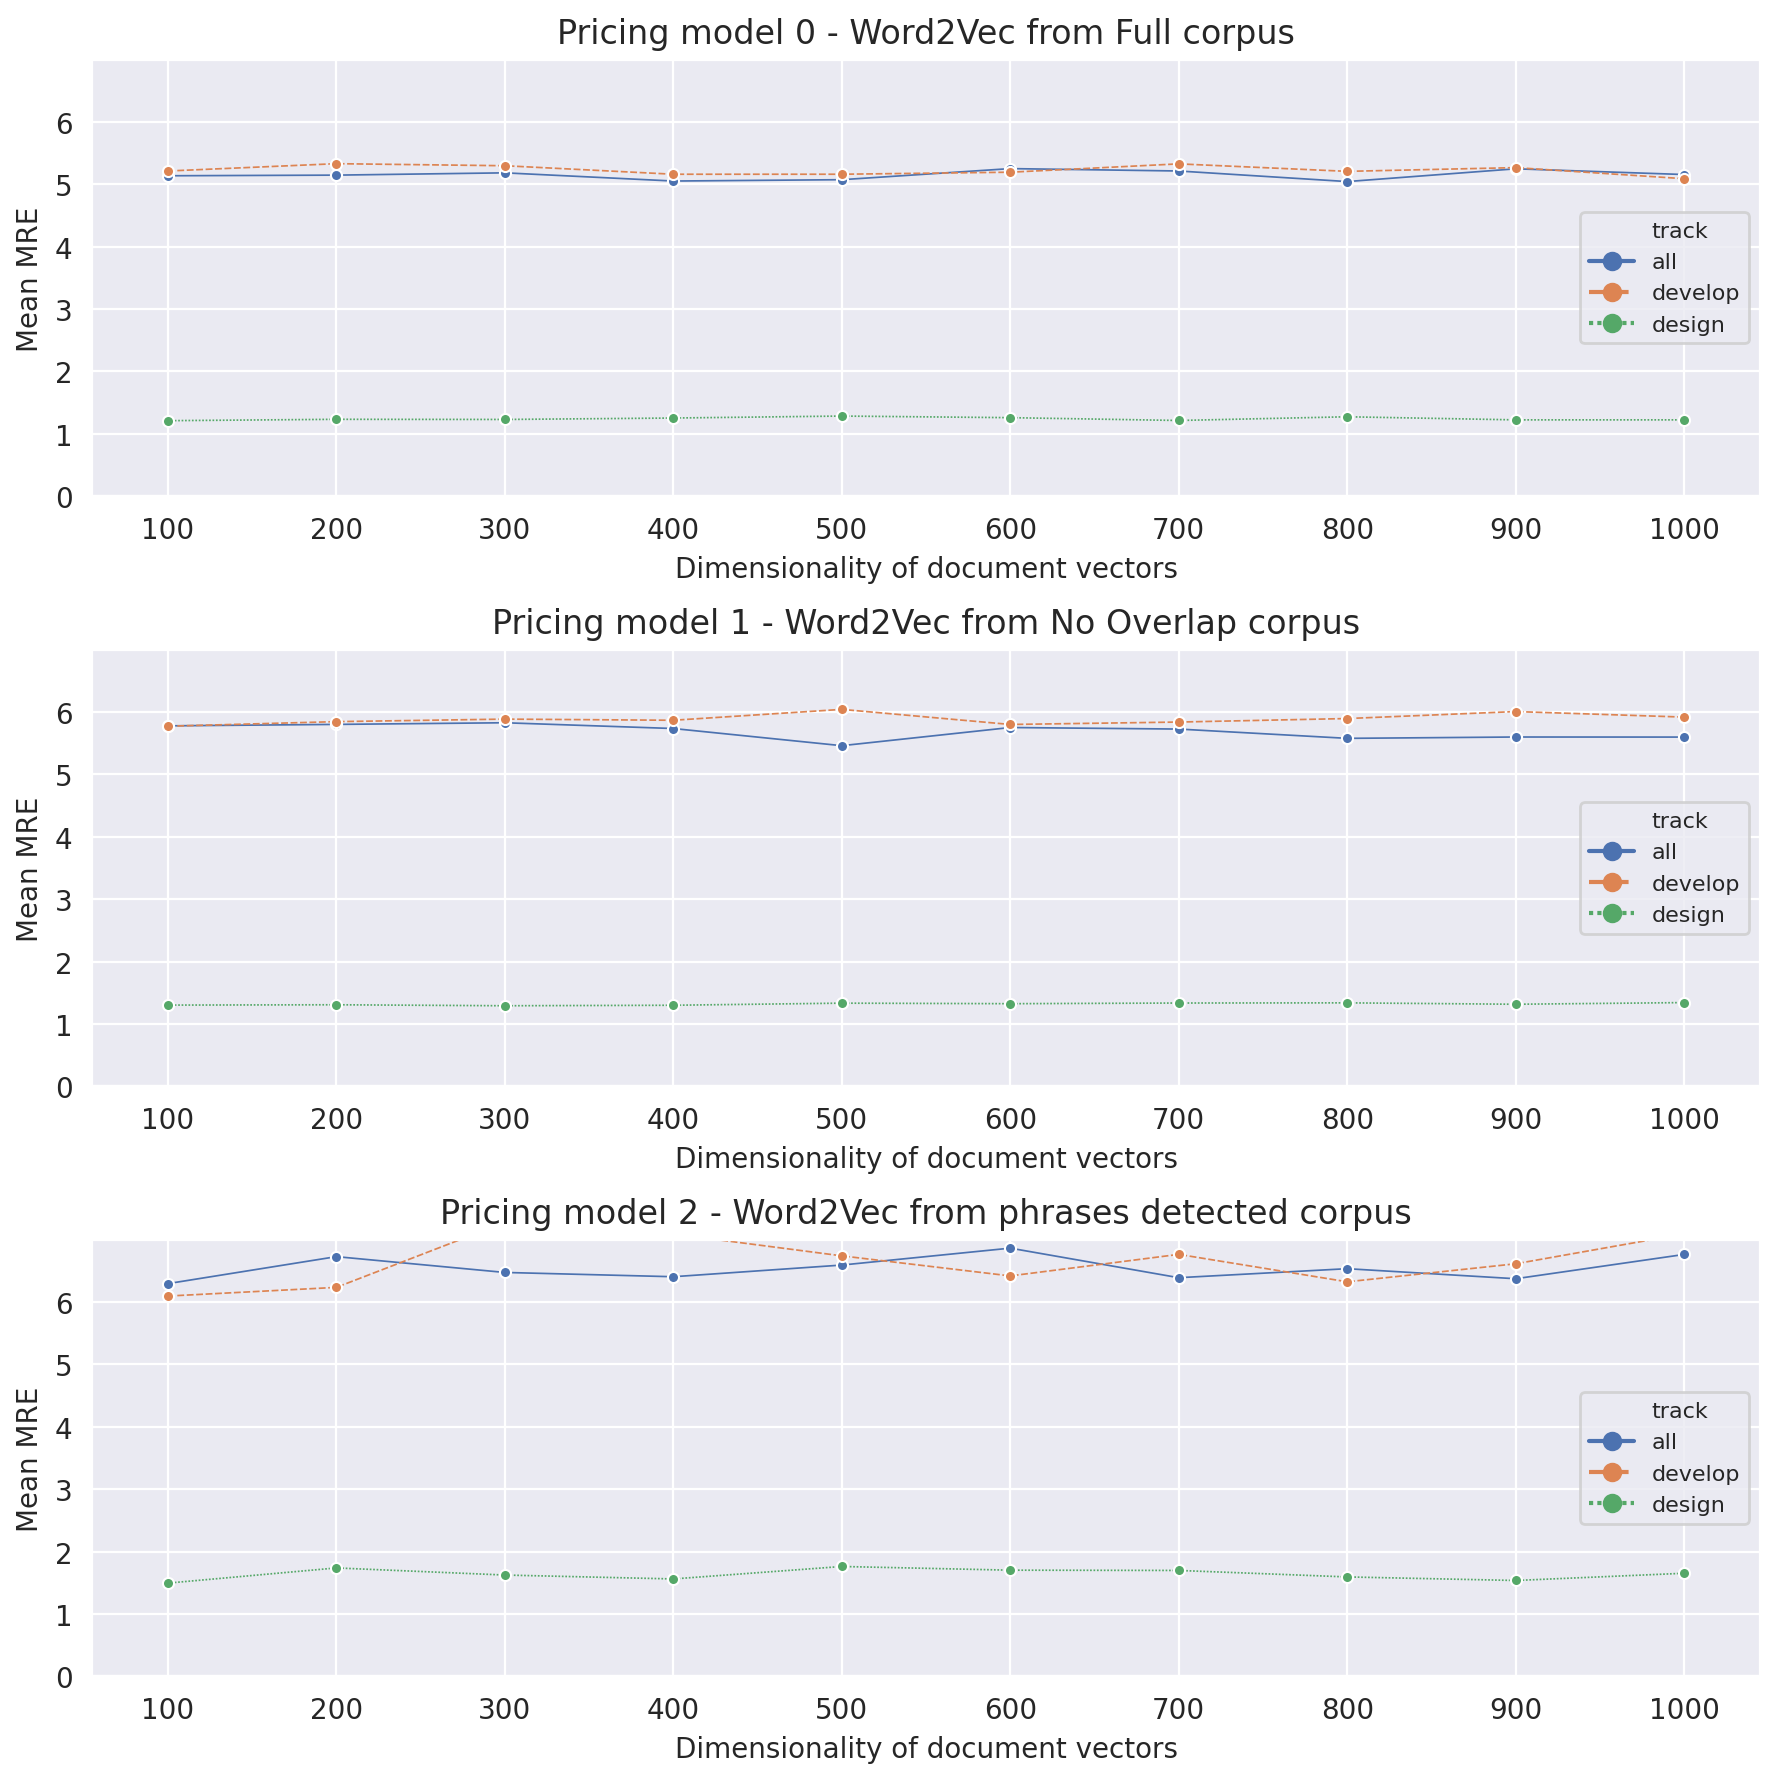

In [16]:
title_text = [
    'Word2Vec from Full corpus',
    'Word2Vec from No Overlap corpus',
    'Word2Vec from phrases detected corpus',
    'Word2Vec from Full corpus - median'
]

with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(len(MODELS), 1, figsize=(9, 3 * len(MODELS)), dpi=200)

    for i, model in enumerate(MODELS):
        ax = axes[i]

        sns.lineplot(
            data=mmre_df.loc[mmre_df.model == model],
            x='dimension',
            y='mmre',
            hue='track',
            style='track',
            palette='deep',
            linewidth=0.618,
            markers=['o', 'o', 'o'],
            markersize=4,
            ax=ax
        )

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, prop={'size': 8})

        ax.set_xticks(list(range(100, 1100, 100)))
        ax.set_xticklabels(labels=list(range(100, 1100, 100)))
        ax.set_ylim(top=7, bottom=0)
        ax.set_yticks(list(range(7)))
        ax.set_yticklabels(labels=list(range(7)))

        ax.set_xlabel('Dimensionality of document vectors')
        ax.set_ylabel('Mean MRE')
        ax.set_title(f'Pricing model {model} - {title_text[i]}')

    fig.tight_layout()
    fig.savefig('img/pm012_results.png', dpi='figure')

Unexpectedly, with the removal of overlap sections and phrases detected. **The accuracy of the pricing models decrease.**

This result is against the assumption I made that with the refinement of the input corpus, the accuracy will increase.

> Note: All three models have removed the stop words from the cropus

To better demo the decreasement of models. I plot the MREs by track in different model below.

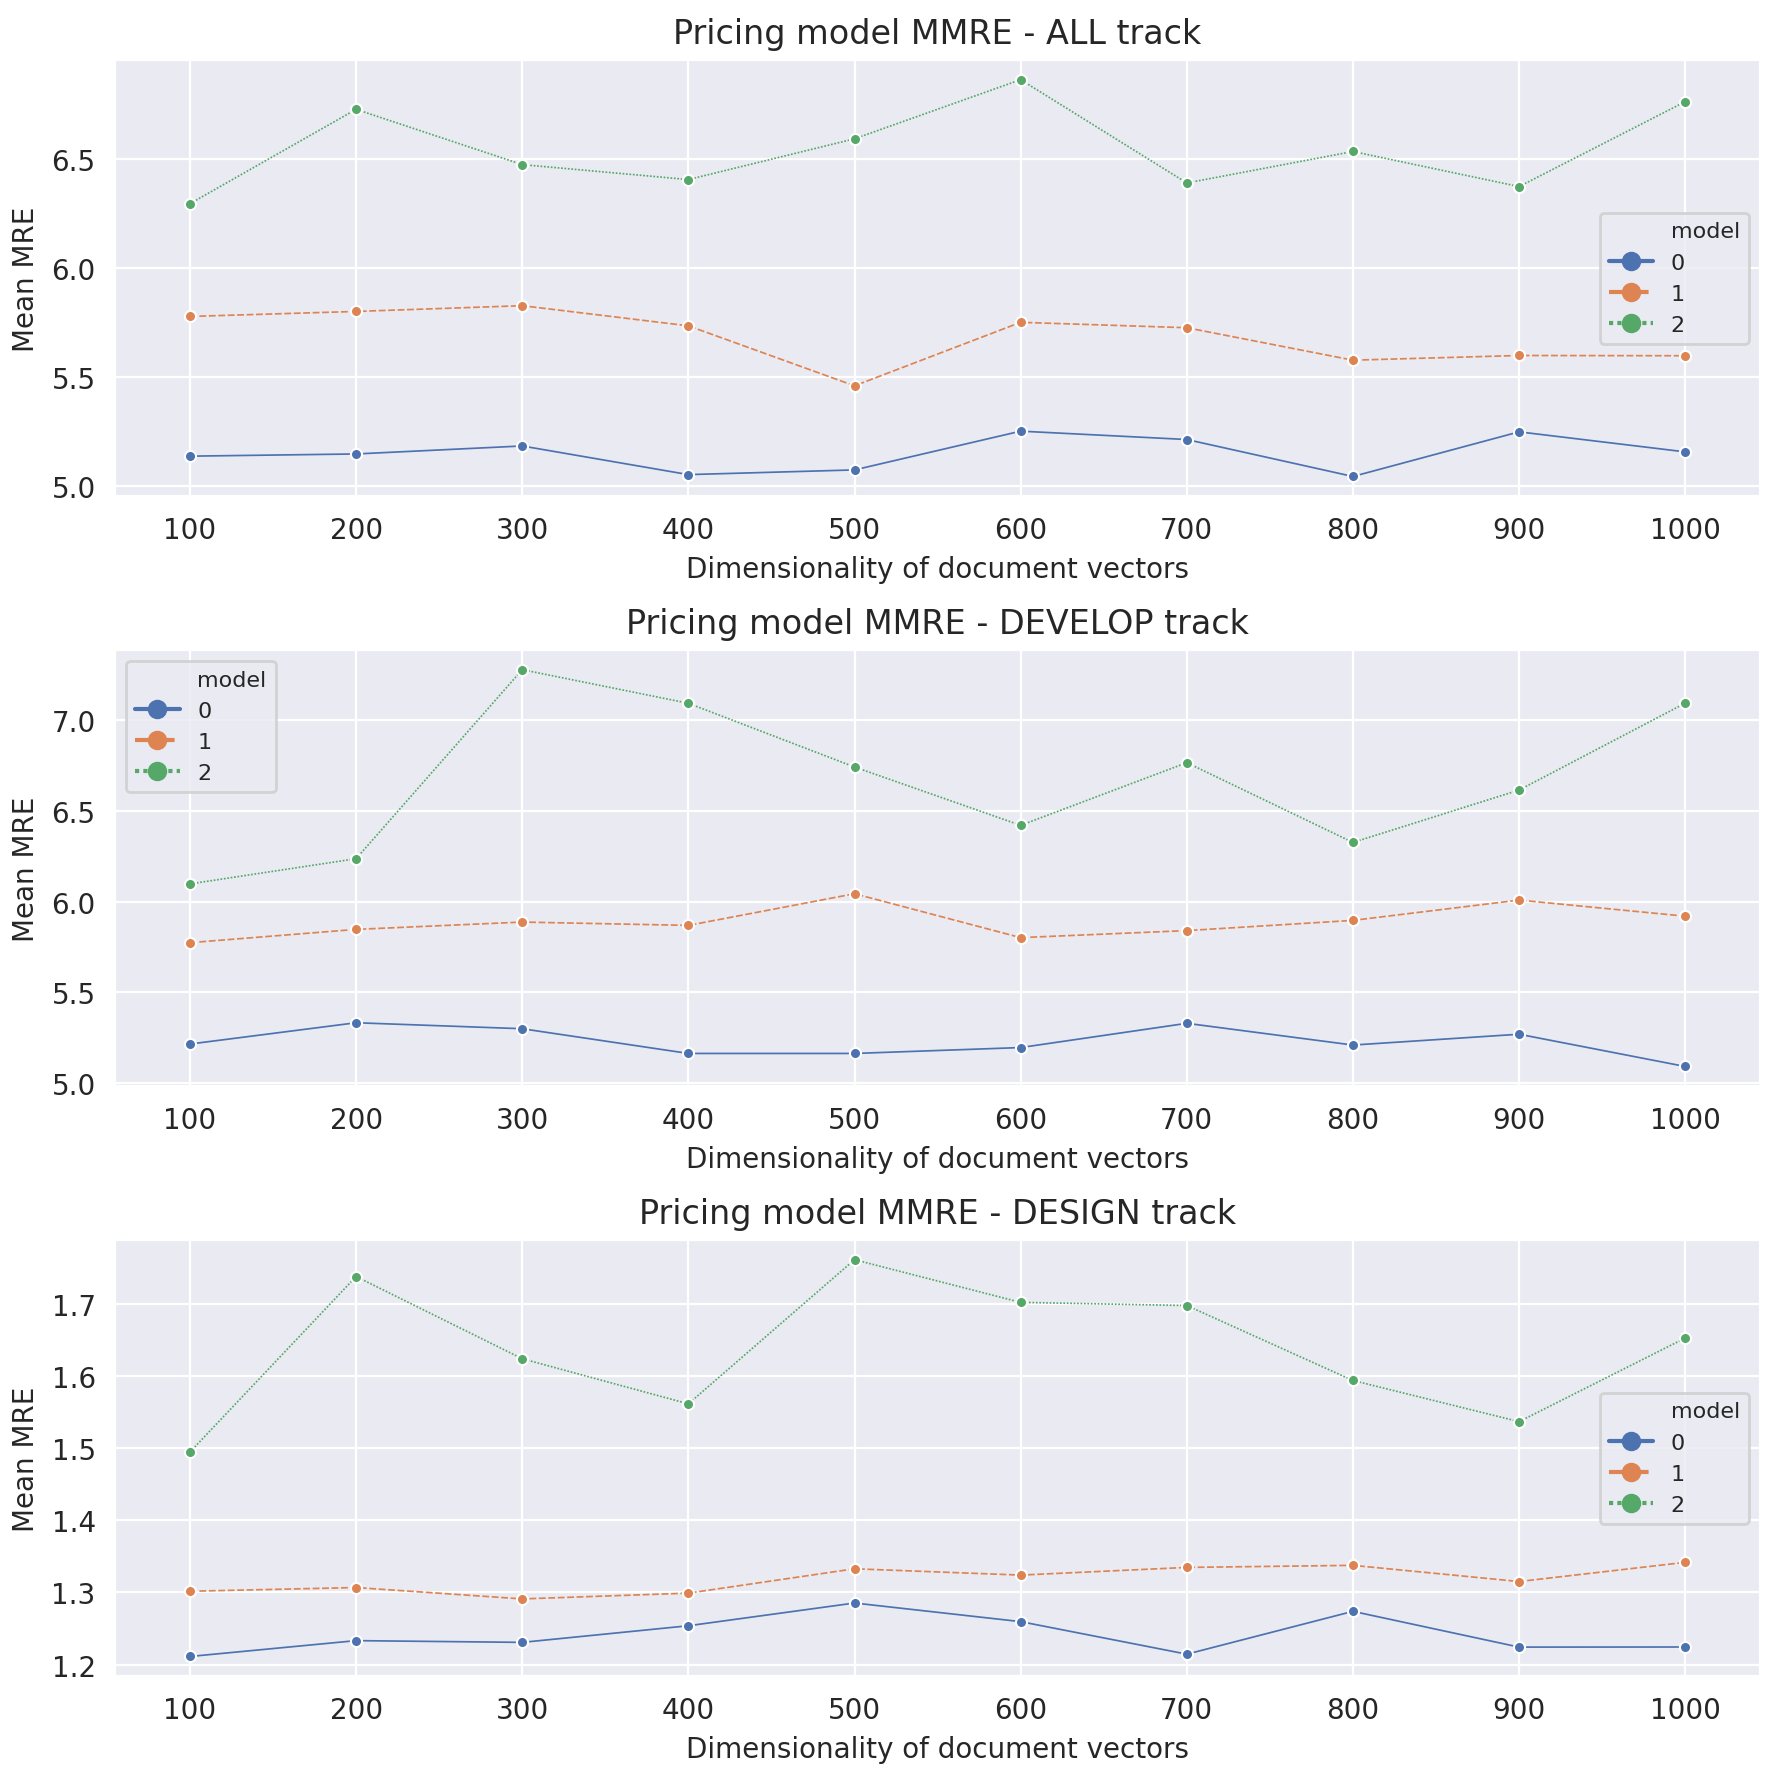

In [17]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(3, 1, figsize=(9, 9), dpi=200)

    for idx, track in enumerate(TRACKS):
        ax = axes[idx]
        sns.lineplot(
            data=mmre_df.loc[mmre_df.track == track],
            x='dimension',
            y='mmre',
            hue='model',
            style='model',
            palette='deep',
            linewidth=0.618,
            markers=['o'] * len(MODELS),
            markersize=4,
            ax=ax
        )

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, prop={'size': 8})

        ax.set_xticks(list(range(100, 1100, 100)))
        ax.set_xticklabels(labels=list(range(100, 1100, 100)))
        # ax.set_ylim(top=7, bottom=0)
        # ax.set_yticks(list(range(7)))
        # ax.set_yticklabels(labels=list(range(7)))

        ax.set_xlabel('Dimensionality of document vectors')
        ax.set_ylabel('Mean MRE')
        ax.set_title(f'Pricing model MMRE - {track.upper()} track')

    fig.tight_layout()
    fig.savefig('img/pm012_results_comparison.png', dpi='figure')

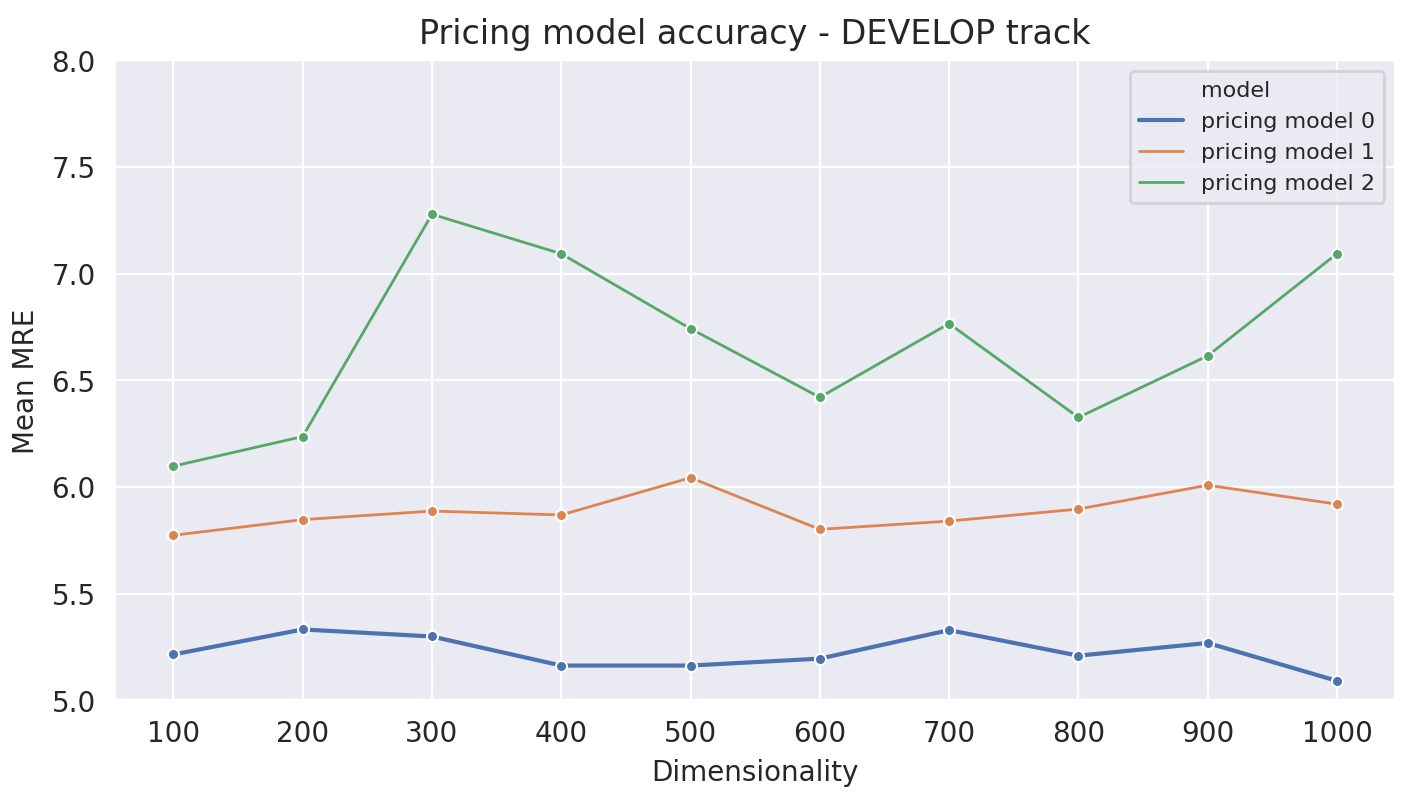

In [18]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(8, 4), dpi=200)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    sns.lineplot(
        data=mmre_df.loc[(mmre_df.track == 'develop') & (mmre_df.model != 3)],
        x='dimension',
        y='mmre',
        hue='model',
        size='model',
        sizes=[1.5, 1, 1],
        palette='deep',
#         linewidth=1.5,
#         markers=['o'] * len(MODELS),
        marker='o',
        markersize=4,
        ax=ax
    )
    
    ax.set_xticks(list(range(100, 1100, 100)))
    ax.set_xticklabels(labels=list(range(100, 1100, 100)))
    ax.set_ylim(bottom=5, top=8)
    
    ax.set_xlabel('Dimensionality')
    ax.set_ylabel('Mean MRE')
    ax.set_title('Pricing model accuracy - DEVELOP track')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [f'pricing model {m}' if m != 'model' else 'model' for m in labels], prop={'size': 8})
    
    fig.savefig('img/pm012_dev_track_comparison', dpi='figure')

## KNN algorithm result

I trained the KNN model by using concatenation of metadata of challenges and document vectors from pm0 as input `X` and actual prize as input `y` and run 10-fold cross validation to assess the model. The mean MRE is rather positive.

Comparing to the pricing model 0, which is based on text mining and analogy estimation, the KNN approach has a rather obivious performance boost.

**What next?**

1. I've been trying the paragraph vector (`gensim.models.Doc2Vec`) as another approach to the document vector, but the computing resource required is too large, it will take some time.

2. Add more meta data dimensions. *

3. relation between subtrack and prize
  - violin plot
  
_Size_ and _Workload_ relation

raw dataset could be discrete.

In [7]:
pm4_measure_df = {}
for stat in ('mean', 'median'):
    with open(os.path.join(os.curdir, 'pricing_model_4', 'measures', f'measure_FF_600D_{stat}.json')) as f:
        pm4_measure_df[stat] = pd.read_json(f, orient='records').set_index('index')

In [8]:
pm4_measure_df['median']['MRE'].mean()

3.437418729627209

In [9]:
mmre_df.loc[(mmre_df.track == 'develop') & (mmre_df.model == 0) & (mmre_df.dimension == 600)]['mmre']

15    5.19539
Name: mmre, dtype: float64

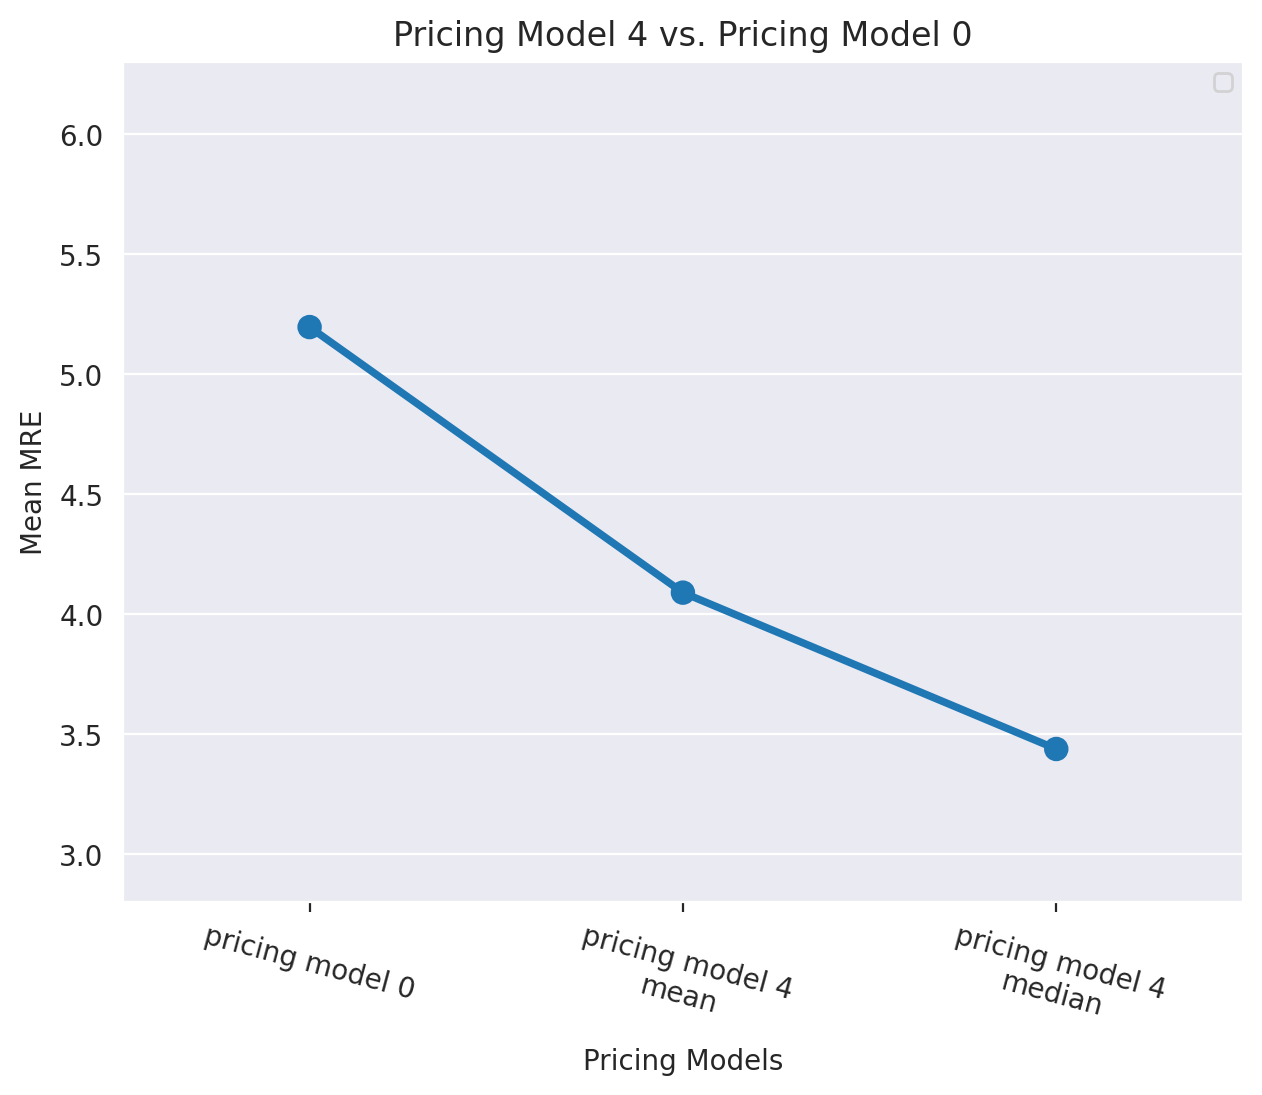

In [15]:
with sns.axes_style('darkgrid', {'xtick.bottom': True}):
    fig = plt.figure(figsize=(8, 6), dpi=200)
    ax = fig.add_axes([0.15, 0.15, 0.7, 0.7])
    
    sns.pointplot(
        x=['pricing model 0', 'pricing model 4\nmean', 'pricing model 4\nmedian'],
        y=[
            mmre_df.loc[(mmre_df.track == 'develop') & (mmre_df.model == 0) & (mmre_df.dimension == 600)]['mmre'],
            pm4_measure_df['mean']['MRE'].mean(),
            pm4_measure_df['median']['MRE'].mean()
        ],
#         hue=['pricing model 0', 'pricing model 4\nmean', 'pricing model 4\nmedian'],
        ax=ax
    )
    
    ax.set_ylim(bottom=2.8, top=6.3)
    ax.set_xticklabels(labels=['pricing model 0', 'pricing model 4\nmean', 'pricing model 4\nmedian'], rotation=345)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, prop={'size': 8})
    
    ax.set_xlabel('Pricing Models')
    ax.set_ylabel('Mean MRE')
    ax.set_title('Pricing Model 4 vs. Pricing Model 0')

    
#     fig.savefig(os.path.join(os.pardir, os.pardir, 'presentation', 'presentation1', 'pm_model4_result.png'), dpi='figure')

In [ ]:
pm4_measure_df['median'].join(topcoder.challenge_basic_info['subtrack'])

In [11]:
pm5_measure_df = {}
for i in range(5):
    with open(os.path.join(os.curdir, 'pricing_model_5', f'knn_measure_{i}.json')) as f:
        pm5_measure_df[i] = pd.read_json(f, orient='records').set_index('index')

/Users/benjamin/Documents/Academy/SSW900/code/DataAnalysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


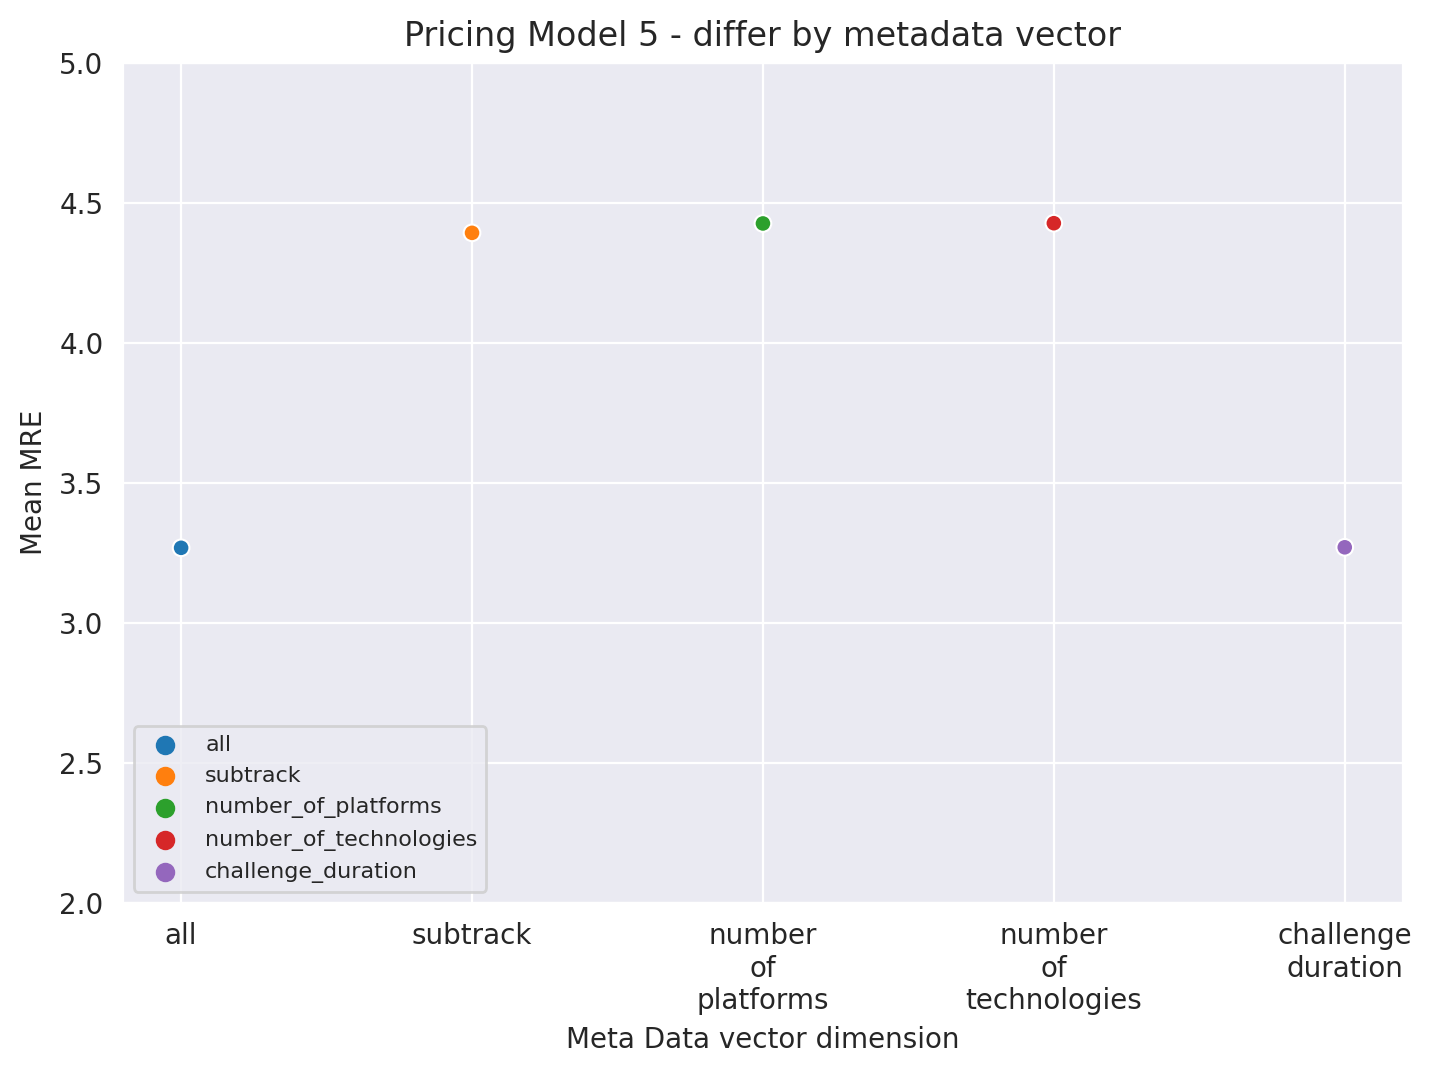

In [12]:
x = ['all', 'subtrack', 'number_of_platforms', 'number_of_technologies', 'challenge_duration']
y = [df['MRE'].mean() for df in pm5_measure_df.values()]
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(8, 6), dpi=200)
    ax = fig.add_axes([0.1, 0.15, 0.8, 0.7])
    
    sns.scatterplot(x=x, y=y, hue=x, ax=ax)
    
    ax.set_ylim(bottom=2, top=5)
    ax.set_xticklabels(labels=['\n'.join([w for w in i.split('_')]) for i in x])
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, prop={'size': 8})
    
    ax.set_xlabel('Meta Data vector dimension')
    ax.set_ylabel('Mean MRE')
    ax.set_title('Pricing Model 5 - differ by metadata vector')
    
#     fig.savefig(os.path.join(os.pardir, os.pardir, 'presentation', 'presentation1', 'pm_model5_result.png'), dpi='figure')

In [13]:
pm5_all_meta = [2.747983620506332,
                0.8679247258002492,
                2.94423992727525,
                1.2936881883309923,
                9.79137191234242,
                1.0955334873771945,
                2.05885069744948,
                6.948144116625358,
                2.599887111152642,
                2.34076405590421]
    
pm5_num_of_platf = [2.9695864514871535,
 0.9944216435736005,
 3.00411338714871,
 1.3694908578836618,
 9.814171321044233,
 1.4956205818841666,
 2.1198146424054984,
 17.871945913234256,
 2.509684526313345,
 2.114763646154109]

mmre_by_fold = pd.DataFrame({'challenge_duration': pm5_all_meta, 'num_of_platform': pm5_num_of_platf}).melt()
mmre_by_fold.columns = ['meta', 'mmre']
mmre_by_fold['fold'] = list(range(10)) * 2

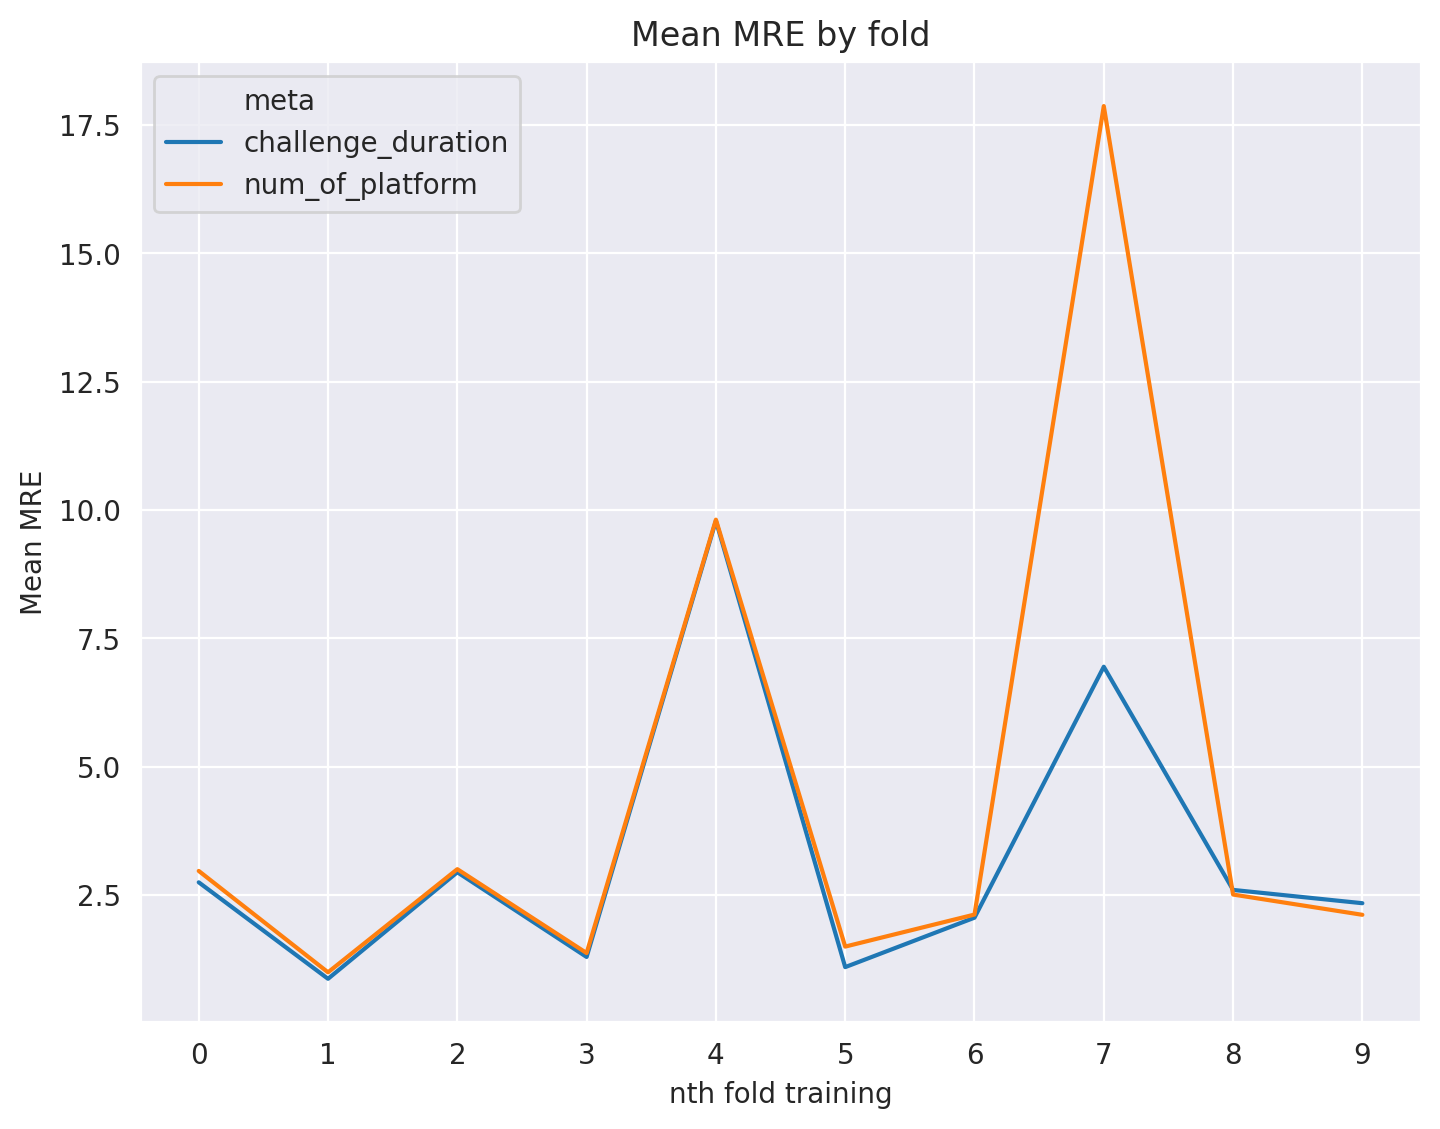

In [14]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(8, 6), dpi=200)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    sns.lineplot(
        data=mmre_by_fold,
        x='fold',
        y='mmre',
        hue='meta',
        ax=ax
    )
    
    ax.set_xticks(list(range(10)))
    ax.set_xlabel('nth fold training')
    ax.set_ylabel('Mean MRE')
    
    ax.set_title('Mean MRE by fold')

#     fig.savefig(os.path.join(os.pardir, os.pardir, 'presentation', 'presentation1', 'pm_model5_result_by_fold.png'), dpi='figure')